In [ ]:
# from sklearn.manifold import MDS
# import pandas as pd

# # data = load.readPd('dataset/gauss_data.txt')
# dis = load.disM_line('dataset/example_distances.txt')
# mds = MDS(n_components=2, dissimilarity='precomputed')
# data = mds.fit_transform(dis)
# data = pd.DataFrame(data, columns=['x', 'y'])


In [1]:
from load import *

load = load_xy('dataset/xy/')


399
[1 2 3 4 5 6]
         x      y  clusterID
73   36.05  18.75          2
1    29.80  22.15          1
124  33.35  16.05          2
176  11.50  17.10          3
210  19.20  18.80          4


<AxesSubplot:xlabel='x', ylabel='y'>

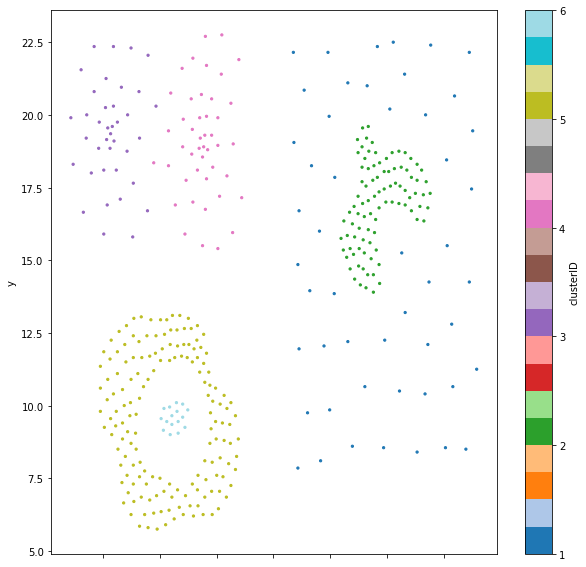

In [23]:
data = next(load)
print(len(data))
print(data['clusterID'].unique())
print(data.sample(5))
data.plot.scatter(x='x', y='y', c='clusterID', colormap='tab20', s=5, figsize=(10, 10))


dc: 3.301514803843839
103
[103 394 208]


[Text(0.5, 1.0, 'decision graph'),
 Text(0.5, 0, '$\\rho$'),
 Text(0, 0.5, '$\\delta$')]

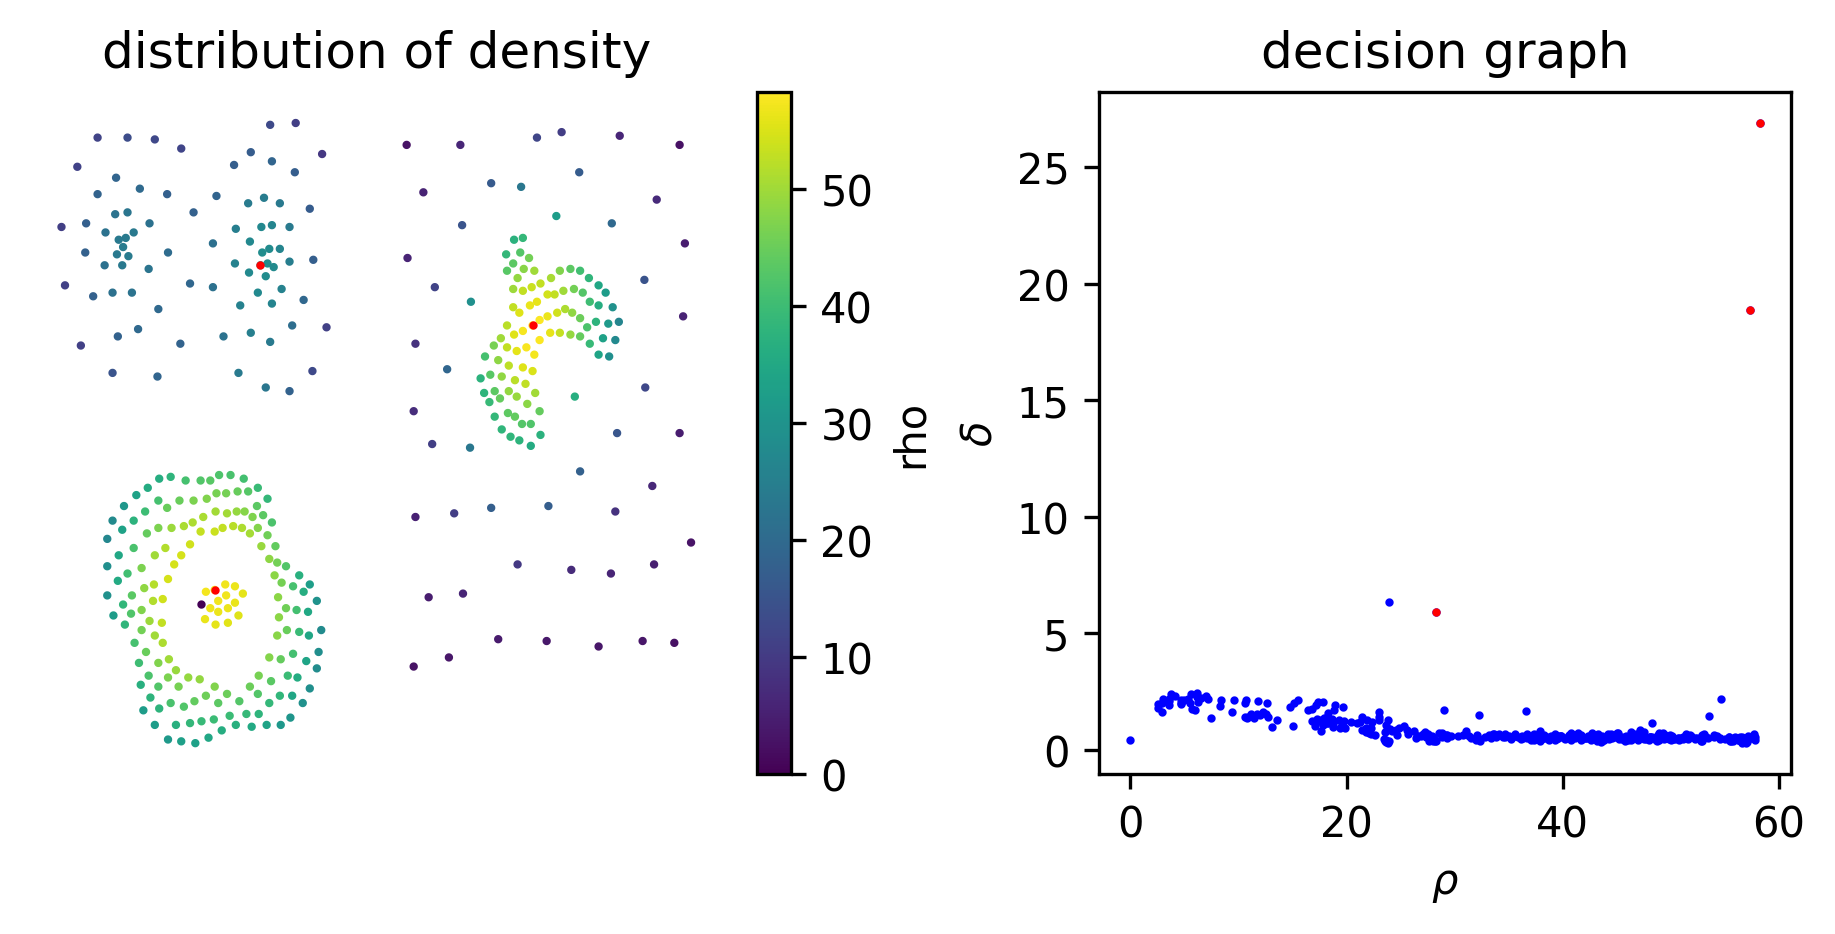

In [24]:
from DPC import DPC

dpc = DPC(data[['x', 'y']])
dpc.calDis()
dpc.calDc_raw(0.1)
dpc.calRho()
dpc.calDel()
dpc.calGam()

dpc.getCen(3)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300, constrained_layout=True)
dpc.df.plot.scatter(x="x", y='y', c='rho', cmap='viridis', s=1, ax=ax[0])
dpc.df.plot.scatter(x="rho", y='delta', c='blue', s=1, ax=ax[1])

for i in dpc.centers:
    ax[0].scatter(dpc.df.loc[i, 'x'], dpc.df.loc[i, 'y'], c='red',s=1)
    ax[1].scatter(dpc.df.loc[i, 'rho'], dpc.df.loc[i, 'delta'], c='red',s=1)

# i = 2336
# ax[0].scatter(data.loc[i, 'x'], data.loc[i, 'y'], c='r', s=2)

ax[0].set_axis_off()
ax[0].set(title='distribution of density')
ax[1].set(title='decision graph', xlabel=r'$\rho$', ylabel=r'$\delta$')


<AxesSubplot:ylabel='Frequency'>

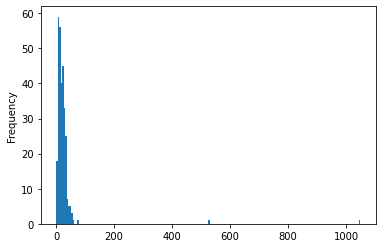

In [20]:
dpc.df['gamma'].plot.hist(bins=200)

In [25]:
import matplotlib.pyplot as plt
dpc.cluster()

print(np.sort(dpc.df['clusterID'].unique()))



0 103
1 394
2 208
[1. 2. 3.]


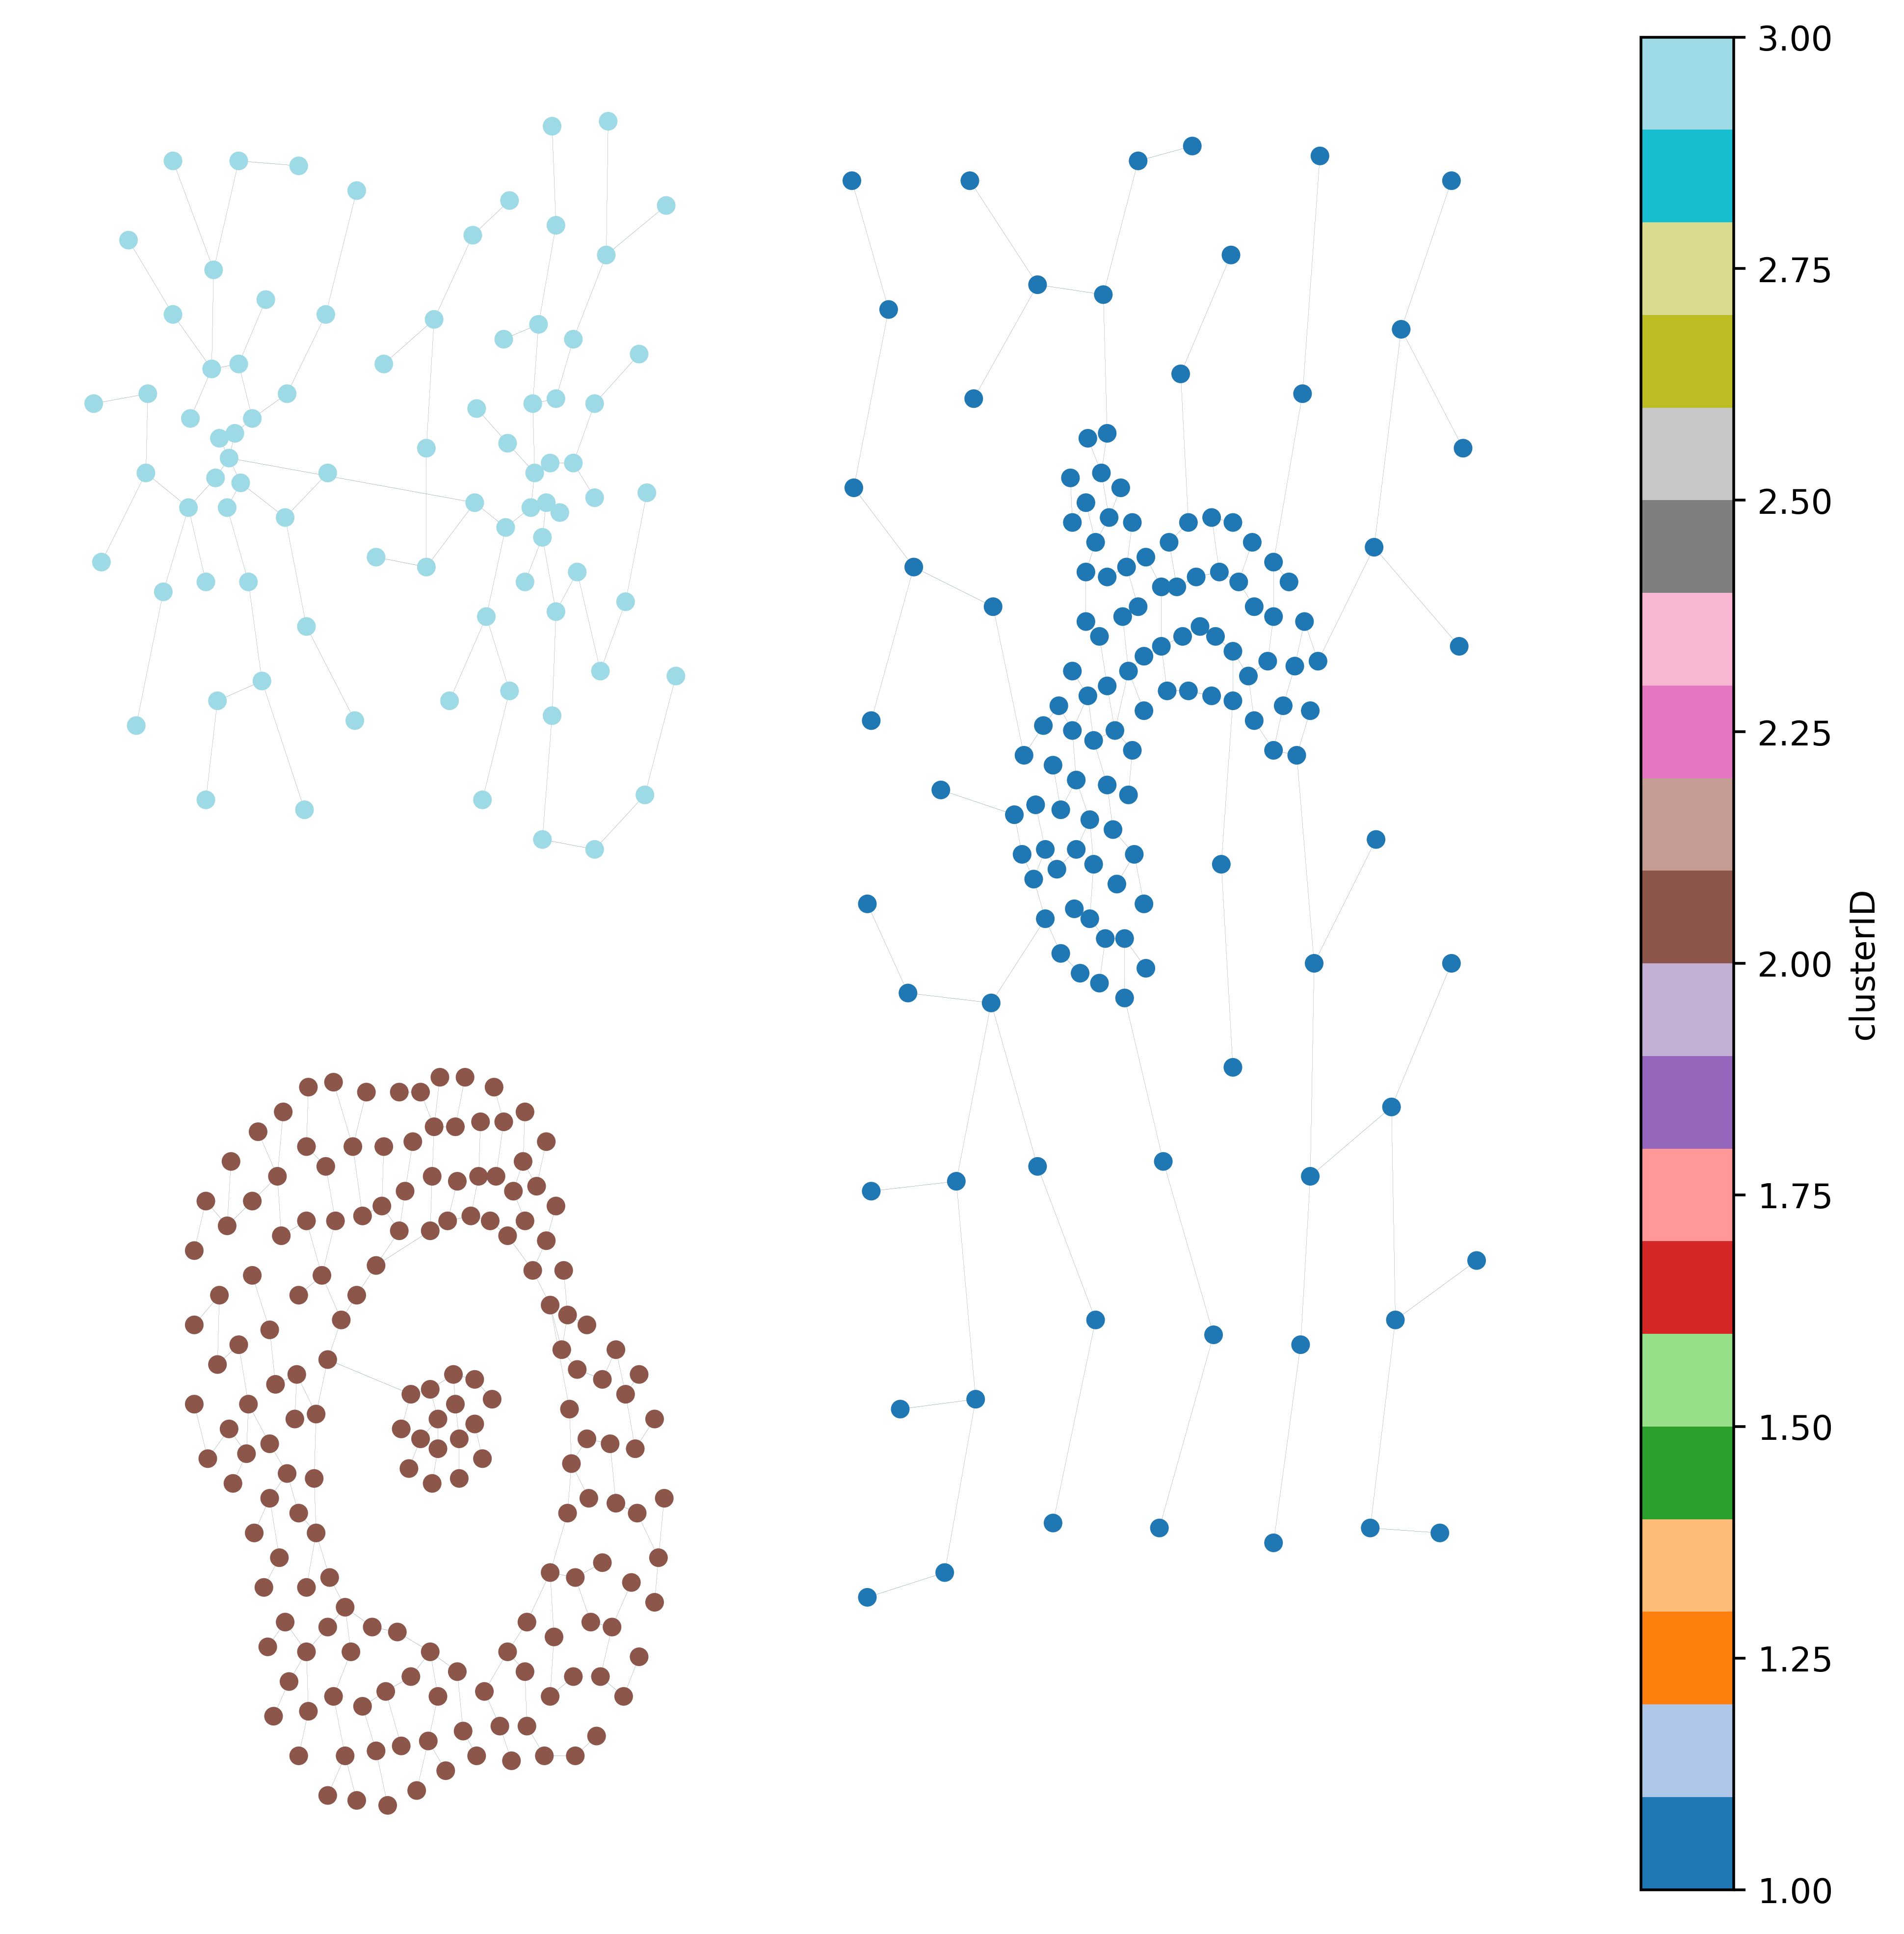

In [26]:

fig, ax = plt.subplots(figsize=(10, 10), dpi=500)
for i, ri in dpc.df.drop(dpc.centers).iterrows():
    ax.arrow(ri['x'], ri['y'], dpc.df.loc[ri['toh'], 'x']-ri['x'], dpc.df.loc[ri['toh'], 'y']-ri['y'], lw=0.01, head_width=0.02)
# dpc.df.plot.scatter(x="x", y='y', s=1, c='rho', cmap='viridis', ax=ax)
# for i in [dpc.centers[7]]:
#     ax.scatter(dpc.df.loc[i,'x'],dpc.df.loc[i,'y'],c='r')

dpc.df.plot.scatter(x='x', y='y', c='clusterID', cmap='tab20', ax=ax)
ax.set_axis_off()
